# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 374 µs (started: 2023-02-18 22:06:58 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
#import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
)
from keras.models import Model
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.36 s (started: 2023-02-18 22:06:58 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'VGG16'
FC_LAYER = 4096

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

# print('versión TF:', tf.__version__) # versión TF: 2.8.0
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

versión Keras: 2.11.0
time: 2.02 ms (started: 2023-02-18 22:07:02 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 23.2 s (started: 2023-02-18 22:07:02 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''

    train_images = np.load(PATH+'train_imgs_8G.npz')['arr_0']
    train_labels = np.load(PATH+'train_labels_8G.npz')['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+'val_imgs_8G.npz')['arr_0']
    val_labels = np.load(PATH+'val_labels_8G.npz')['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    test_images = np.load(PATH+'test_imgs_8G.npz')['arr_0']
    test_labels = np.load(PATH+'test_labels_8G.npz')['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def avg_wts(weights):
    '''
    Function that calculates average of weights along the channel axis
    '''

    #Find mean along the channel axis (second to last axis)
    average_weights = np.mean(
        weights, axis=-2).reshape(weights[:,:,-1:,:].shape
    )  
    return(average_weights)


def configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL):
    vgg_model = keras.applications.VGG16(
        include_top=False, 
        weights='imagenet'
    )

    # Get the dictionary of config for vgg16
    vgg_config = vgg_model.get_config()


    vgg_config["layers"][0]["config"]["batch_input_shape"] = (
        None, HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL
    )

    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)

    # Get the configuration for the updated model and extract layer names. 
    # We will use these names to copy over weights from the original model. 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

    # Name of the first convolutional layer.
    # Remember that this is the only layer with new additional weights. 
    # All other layers will have same weights as the original model. 
    first_conv_name = vgg_updated_layer_names[1]

    # Update weights for all layers. 
    # And for the first conv layer replace weights with average of all 3 channels. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:
         

            if layer.get_weights() != []:
                target_layer = vgg_updated.get_layer(layer.name)
        
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
              
                    weights_single_channel = avg_wts(weights)
                                                        
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
        
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want. 

    return vgg_updated


def create_custom_model(NUM_CLASSES, FC_LAYER):

    # KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
    last_layer = vgg_updated.layers[-1].output

    x = Flatten(name='flatten', input_shape=vgg_updated.output_shape[1:])(last_layer)
    x = Dense(FC_LAYER, activation='relu', name='fc1')(x)
    x = Dense(FC_LAYER, activation='relu', name='fc2')(x)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # activation relu??
    custom_model = Model(vgg_updated.inputs, out)

    for layer in custom_model.layers[:-3]: # Hasta aquí llega hasta flatten
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time:")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER):
    '''Guardar el modelo en disco duro
    
    Args:
        - TYPE_IMG: regular o inverted
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model: Modelo de Deep Learning
        - TYPE_IMG: regular o inverted
        - USE_DATA_AUG= sin_DA o con_DA
        - DNN_NAME= nombre de la Deep Neural Network. Ej: VGG19 o DenseNet121
        - FC_LAYER: Número de capas Dense. En este caso es 4096
    '''
    
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl8_imgs{SIZE}_' \ 
                + TYPE_IMG +f'_FC_{FC_LAYER}.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG + f'/{FC_LAYER}/' + MODEL_NAME

    # Por default lo guarda es en el mismo Google Colab's notebook
    custom_model.save(WEIGHTS_PATH)

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 8.83 ms (started: 2023-02-18 22:07:31 +00:00)


# Imgs 64x64

- Test Accuracy: 0.8675972819328308
- Test Loss: 0.6445956230163574
- time: 11min 46s
- F1 score: 0.868767332550537
- Precision score: 0.884063249399793
- Recall: 0.8675972927241963
- epochs: 33/50



## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 669 µs (started: 2023-02-13 17:30:11 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH)

time: 18.5 s (started: 2023-02-13 17:30:11 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)

time: 1.34 ms (started: 2023-02-13 17:30:29 +00:00)


## Preparar el modelo

In [ ]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

58889256/58889256 [==============================] - 4s 0us/step
time: 8.39 s (started: 2023-02-13 17:30:29 +00:00)


In [ ]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 46.3 ms (started: 2023-02-13 17:30:38 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 30s 7ms/step - loss: 4.2114 - sparse_categorical_accuracy: 0.1780 - val_loss: 2.4944 - val_sparse_categorical_accuracy: 0.3894
Epoch 2/50
3325/3325 [==============================] - 21s 6ms/step - loss: 1.9170 - sparse_categorical_accuracy: 0.5121 - val_loss: 1.6048 - val_sparse_categorical_accuracy: 0.5837
Epoch 3/50
3325/3325 [==============================] - 21s 6ms/step - loss: 1.3160 - sparse_categorical_accuracy: 0.6487 - val_loss: 1.2195 - val_sparse_categorical_accuracy: 0.6737
Epoch 4/50
3325/3325 [==============================] - 21s 6ms/step - loss: 1.0208 - sparse_categorical_accuracy: 0.7210 - val_loss: 1.0247 - val_sparse_categorical_accuracy: 0.7249
Epoch 5/50
3325/3325 [==============================] - 21s 6ms/step - loss: 0.8417 - sparse_categorical_accuracy: 0.7658 - val_loss: 0.8738 - val_sparse_categorical_accuracy: 0.7599
Epoch 6/50
3325/3325 [==============================] - 21s 6ms/step - loss: 0.7216 -

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH)

time: 2.77 s (started: 2023-02-13 17:42:24 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 2s 5ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.8676
_________________________________________________________________________________________________________________________________
Test Accuracy:
0.8675972819328308
_________________________________________________________________________________________________________________________________
Test Loss:
0.6445956230163574
444/444 [==============================] - 2s 3ms/step
_________________________________________________________________________________________________________________________________
- F1 score
0.868767332550537

- Precision score
0.884063249399793

- Recall
0.8675972927241963
*********************************************************************************************************************************

time: 5.01 s (started: 2023-02-13 17:42:27 +00:00)


## Graficando

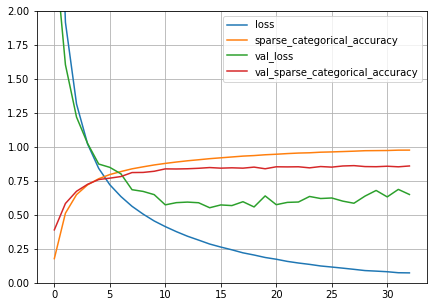

time: 244 ms (started: 2023-02-13 17:42:32 +00:00)


In [ ]:
plot_loss(history)

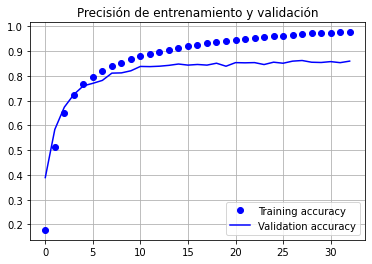

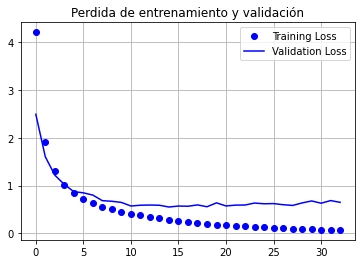

time: 325 ms (started: 2023-02-13 17:42:32 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 3.37 s (started: 2023-02-13 17:45:17 +00:00)


# Imgs 96x96

- Test Accuracy: 0.9133530855178833
- Test Loss: 0.43802472949028015
- time: 
time: 15min 40s
- F1 score: 0.9136916806641953
- Precision score: 0.9255163886915257
- Recall:  0.9133530738860688
- Epoch: 33/50

## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 566 µs (started: 2023-02-18 22:08:28 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH)

time: 16.3 s (started: 2023-02-18 22:08:29 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)

time: 1.51 ms (started: 2023-02-18 22:08:45 +00:00)


## Preparar el modelo

In [ ]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

58889256/58889256 [==============================] - 0s 0us/step
time: 4.52 s (started: 2023-02-18 22:08:45 +00:00)


In [ ]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 46 ms (started: 2023-02-18 22:08:49 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 38s 9ms/step - loss: 3.2977 - sparse_categorical_accuracy: 0.3298 - val_loss: 1.3838 - val_sparse_categorical_accuracy: 0.6292
Epoch 2/50
3325/3325 [==============================] - 28s 8ms/step - loss: 0.9758 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.8251 - val_sparse_categorical_accuracy: 0.7719
Epoch 3/50
3325/3325 [==============================] - 28s 8ms/step - loss: 0.6327 - sparse_categorical_accuracy: 0.8194 - val_loss: 0.5983 - val_sparse_categorical_accuracy: 0.8263
Epoch 4/50
3325/3325 [==============================] - 28s 8ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.8600 - val_loss: 0.5272 - val_sparse_categorical_accuracy: 0.8435
Epoch 5/50
3325/3325 [==============================] - 28s 8ms/step - loss: 0.3888 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.4438 - val_sparse_categorical_accuracy: 0.8686
Epoch 6/50
3325/3325 [==============================] - 28s 8ms/step - loss: 0.3223 -

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH)

time: 2.05 s (started: 2023-02-18 22:24:30 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 2s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.9133530855178833
- Test Loss: 0.43802472949028015
- time:
- F1 score: 0.9136916806641953
- Precision score: 0.9255163886915257
- Recall:  0.9133530738860688
- Epoch: 
*********************************************************************************************************************************
time: 6.84 s (started: 2023-02-18 22:24:32 +00:00)


## Graficando

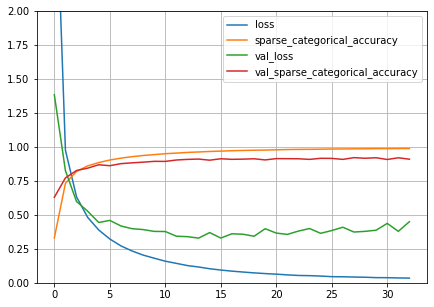

time: 309 ms (started: 2023-02-18 22:24:39 +00:00)


In [ ]:
plot_loss(history)

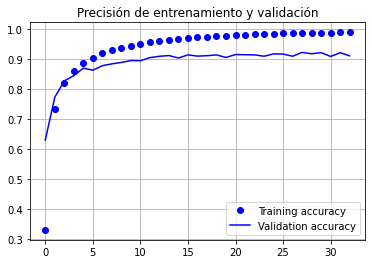

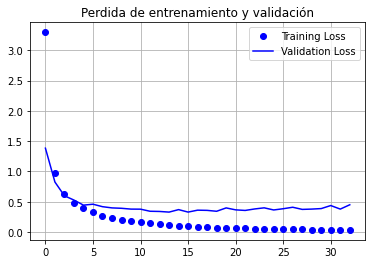

time: 411 ms (started: 2023-02-18 22:24:39 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/4096/model_vgg16_etl8_imgs96_regular_FC_4096.h5-------
time: 2.26 s (started: 2023-02-18 22:24:39 +00:00)


# Imgs 112x112

- Test Accuracy: 0.925197422504425
- Test Loss: 0.3221510946750641
- time: 10min 33s
- F1 score: 0.925362042515304
- Precision score: 0.9353814000735287
- Recall:  0.9251974055273547
- Epoch: 21/50

## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 649 µs (started: 2023-02-18 22:24:42 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH)

time: 18.9 s (started: 2023-02-18 22:24:42 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 1.14 ms (started: 2023-02-18 22:25:00 +00:00)


## Preparar el modelo

In [ ]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 559 ms (started: 2023-02-18 22:25:00 +00:00)


In [ ]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 32.2 ms (started: 2023-02-18 22:25:01 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

## Entrenar modelo


In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 32s 9ms/step - loss: 2.7658 - sparse_categorical_accuracy: 0.4277 - val_loss: 0.9950 - val_sparse_categorical_accuracy: 0.7265
Epoch 2/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.7135 - sparse_categorical_accuracy: 0.7996 - val_loss: 0.5946 - val_sparse_categorical_accuracy: 0.8314
Epoch 3/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.4679 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.4671 - val_sparse_categorical_accuracy: 0.8648
Epoch 4/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.3508 - sparse_categorical_accuracy: 0.8953 - val_loss: 0.4084 - val_sparse_categorical_accuracy: 0.8783
Epoch 5/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.2793 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.3727 - val_sparse_categorical_accuracy: 0.8918
Epoch 6/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.2291 -

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH)

time: 2.51 s (started: 2023-02-18 22:35:35 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 2s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.925197422504425
- Test Loss: 0.3221510946750641
- time:
- F1 score: 0.925362042515304
- Precision score: 0.9353814000735287
- Recall:  0.9251974055273547
- Epoch: 
*********************************************************************************************************************************
time: 7.39 s (started: 2023-02-18 22:35:38 +00:00)


## Graficando

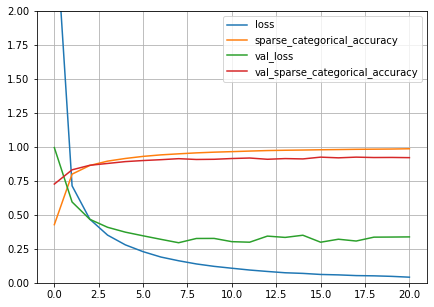

time: 213 ms (started: 2023-02-18 22:35:45 +00:00)


In [ ]:
plot_loss(history)

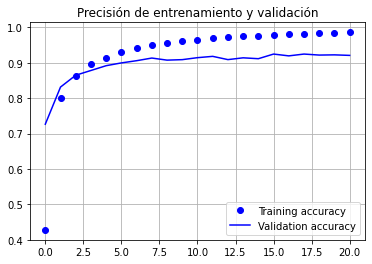

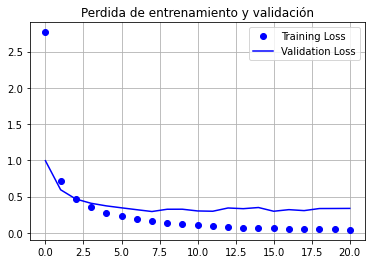

time: 627 ms (started: 2023-02-18 22:35:45 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/4096/model_vgg16_etl8_imgs112_regular_FC_4096.h5-------
time: 1.15 s (started: 2023-02-18 22:35:46 +00:00)


In [ ]:
runtime.unassign()

time: 155 ms (started: 2023-02-18 22:35:47 +00:00)


# Imgs 127x127

- Test Accuracy:  0.9217427968978882
- Test Loss:  0.3205949068069458
- time: 12min
- F1 score:  0.9220738543987848
- Precision score:  0.9337917692200134
- Recall:  0.9217428087986463
- Epoch 18/50

## Cargar imágenes

In [ ]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 733 µs (started: 2023-02-13 18:07:20 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH)

time: 32.2 s (started: 2023-02-13 18:07:20 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 921 µs (started: 2023-02-13 18:07:52 +00:00)


## Preparar el modelo

In [ ]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

58889256/58889256 [==============================] - 3s 0us/step
time: 7.63 s (started: 2023-02-13 18:07:52 +00:00)


In [ ]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 49.1 ms (started: 2023-02-13 18:08:00 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 127, 127, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 127, 127, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 50s 12ms/step - loss: 2.5753 - sparse_categorical_accuracy: 0.4622 - val_loss: 0.9208 - val_sparse_categorical_accuracy: 0.7435
Epoch 2/50
3325/3325 [==============================] - 39s 12ms/step - loss: 0.6197 - sparse_categorical_accuracy: 0.8254 - val_loss: 0.5461 - val_sparse_categorical_accuracy: 0.8448
Epoch 3/50
3325/3325 [==============================] - 39s 12ms/step - loss: 0.3981 - sparse_categorical_accuracy: 0.8832 - val_loss: 0.4322 - val_sparse_categorical_accuracy: 0.8734
Epoch 4/50
3325/3325 [==============================] - 39s 12ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.9119 - val_loss: 0.3707 - val_sparse_categorical_accuracy: 0.8880
Epoch 5/50
3325/3325 [==============================] - 39s 12ms/step - loss: 0.2303 - sparse_categorical_accuracy: 0.9297 - val_loss: 0.3071 - val_sparse_categorical_accuracy: 0.9090
Epoch 6/50
3325/3325 [==============================] - 39s 12ms/step - loss: 0.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH)

time: 4.87 s (started: 2023-02-13 18:20:00 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 3s 7ms/step
*********************************************************************************************************************************
- Test Accuracy:  0.9217427968978882
- Test Loss:  0.3205949068069458
- F1 score:  0.9220738543987848

- Precision score:  0.9337917692200134

- Recall:  0.9217428087986463
*********************************************************************************************************************************

time: 10.1 s (started: 2023-02-13 18:20:05 +00:00)


## Graficando

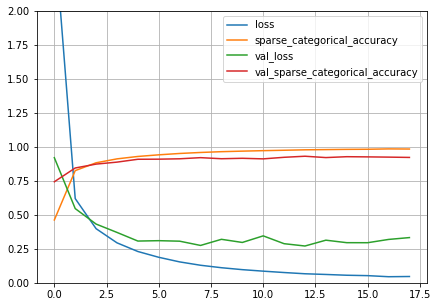

time: 247 ms (started: 2023-02-13 18:20:15 +00:00)


In [ ]:
plot_loss(history)

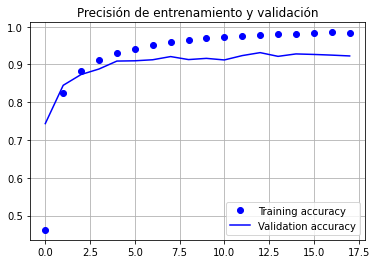

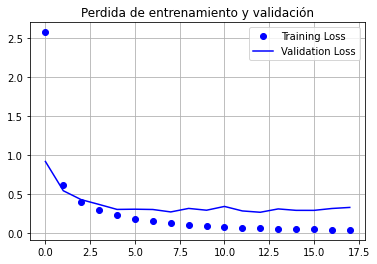

time: 335 ms (started: 2023-02-13 18:20:15 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 2.53 s (started: 2023-02-13 18:20:16 +00:00)
